## Sim Demo

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-08-27 14:27:54.315238: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-27 14:27:57.437963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-27 14:28:00.326217: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  import numpy.matlib 

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run
from sim.wandb_scrape import *

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 18.6%
RAM Usage: 10.2%
Available RAM: 1.3T
Total RAM: 1.5T
52.4G


## Wandb API Query <a id="sims"></a>

Basic test

In [5]:
import wandb
from datetime import datetime, timedelta

api = wandb.Api()

project_path = "alexander-ratzan-new-york-university/gx2conn"

models = ['cge', 'gaussian_kernel', 'exponential_decay', 'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank', 'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']
model_groups = {'feature based': ['cge', 'gaussian_kernel', 'exponential_decay'], 
'bilinear': ['bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank'], 
'non linear': ['dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']}

cv_types = ['random', 'spatial']
feature_types = ['euclidean', 'transcriptome', 'transcriptome_PCA']
null_model = ['none', 'spin']
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 42]
folds = [0, 1, 2, 3]


model = 'cge'
cv_type = 'random'
null_model = 'none'
feature_type = 'transcriptome_PCA'

time_filter = datetime.now() - timedelta(days=30)

filters = {
    "tags": {
        "$all": [
            "final_eval",
            f"model_{model}",
            f"cv_type_{cv_type}",
            f"null_model_{null_model}",
            f"feature_type_{feature_type}"
        ]
    },
    "created_at": {"$gte": time_filter.isoformat()},
    "state": "finished"
}

runs = api.runs(project_path, filters=filters, order="-created_at")
run_data = []
for run in runs:
    # Extract all metrics from final_train_metrics and final_test_metrics
    metrics = {}
    
    if 'final_train_metrics' in run.summary:
        for k, v in run.summary['final_train_metrics'].items():
            metrics[f'train_{k}'] = v
            
    if 'final_test_metrics' in run.summary:
        for k, v in run.summary['final_test_metrics'].items():
            metrics[f'test_{k}'] = v
    
    run_info = {
        'run_name': run.name,
        **metrics
    }
    run_data.append(run_info)

df = pd.DataFrame(run_data)
print(f"\nDataFrame created with {len(df)} runs")
print(f"Columns: {list(df.columns)}")


DataFrame created with 0 runs
Columns: []


Search and plot Random

In [31]:
from collections import defaultdict

# Define model groups and their valid feature types
models = ['cge', 'gaussian_kernel', 'exponential_decay',
          'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank',
          'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']

# Dictionary mapping models to their required feature types
model_feature_types = {
    'cge': ['transcriptome_PCA'],
    'gaussian_kernel': ['euclidean'],
    'exponential_decay': ['euclidean'],
    'bilinear_CM': ['transcriptome', 'transcriptome_PCA'],
    'pls_bilineardecoder': ['transcriptome'],
    'bilinear_lowrank': ['transcriptome'],
    'dynamic_mlp': ['transcriptome', 'transcriptome+euclidean'],
    'shared_transformer': ['transcriptome'],
    'shared_transformer_cls': ['transcriptome']
}

cv_type = 'random'
null_model = 'none'
within_last = 60
before_last = 0

# Store summary DataFrames
summary_dict_random = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_random, within_last=within_last, before_last=before_last)

cv_type = 'random'
null_model = 'spin'

# Store summary DataFrames
summary_dict_random_spin = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_random_spin, within_last=within_last, before_last=before_last)

Checking which model/feature type combinations return 40 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=random, null_model=none, feature_type=transcriptome_PCA
✓ cge with transcriptome_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=random, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=random, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome
✓ bilinear_CM: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=random, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with transcript

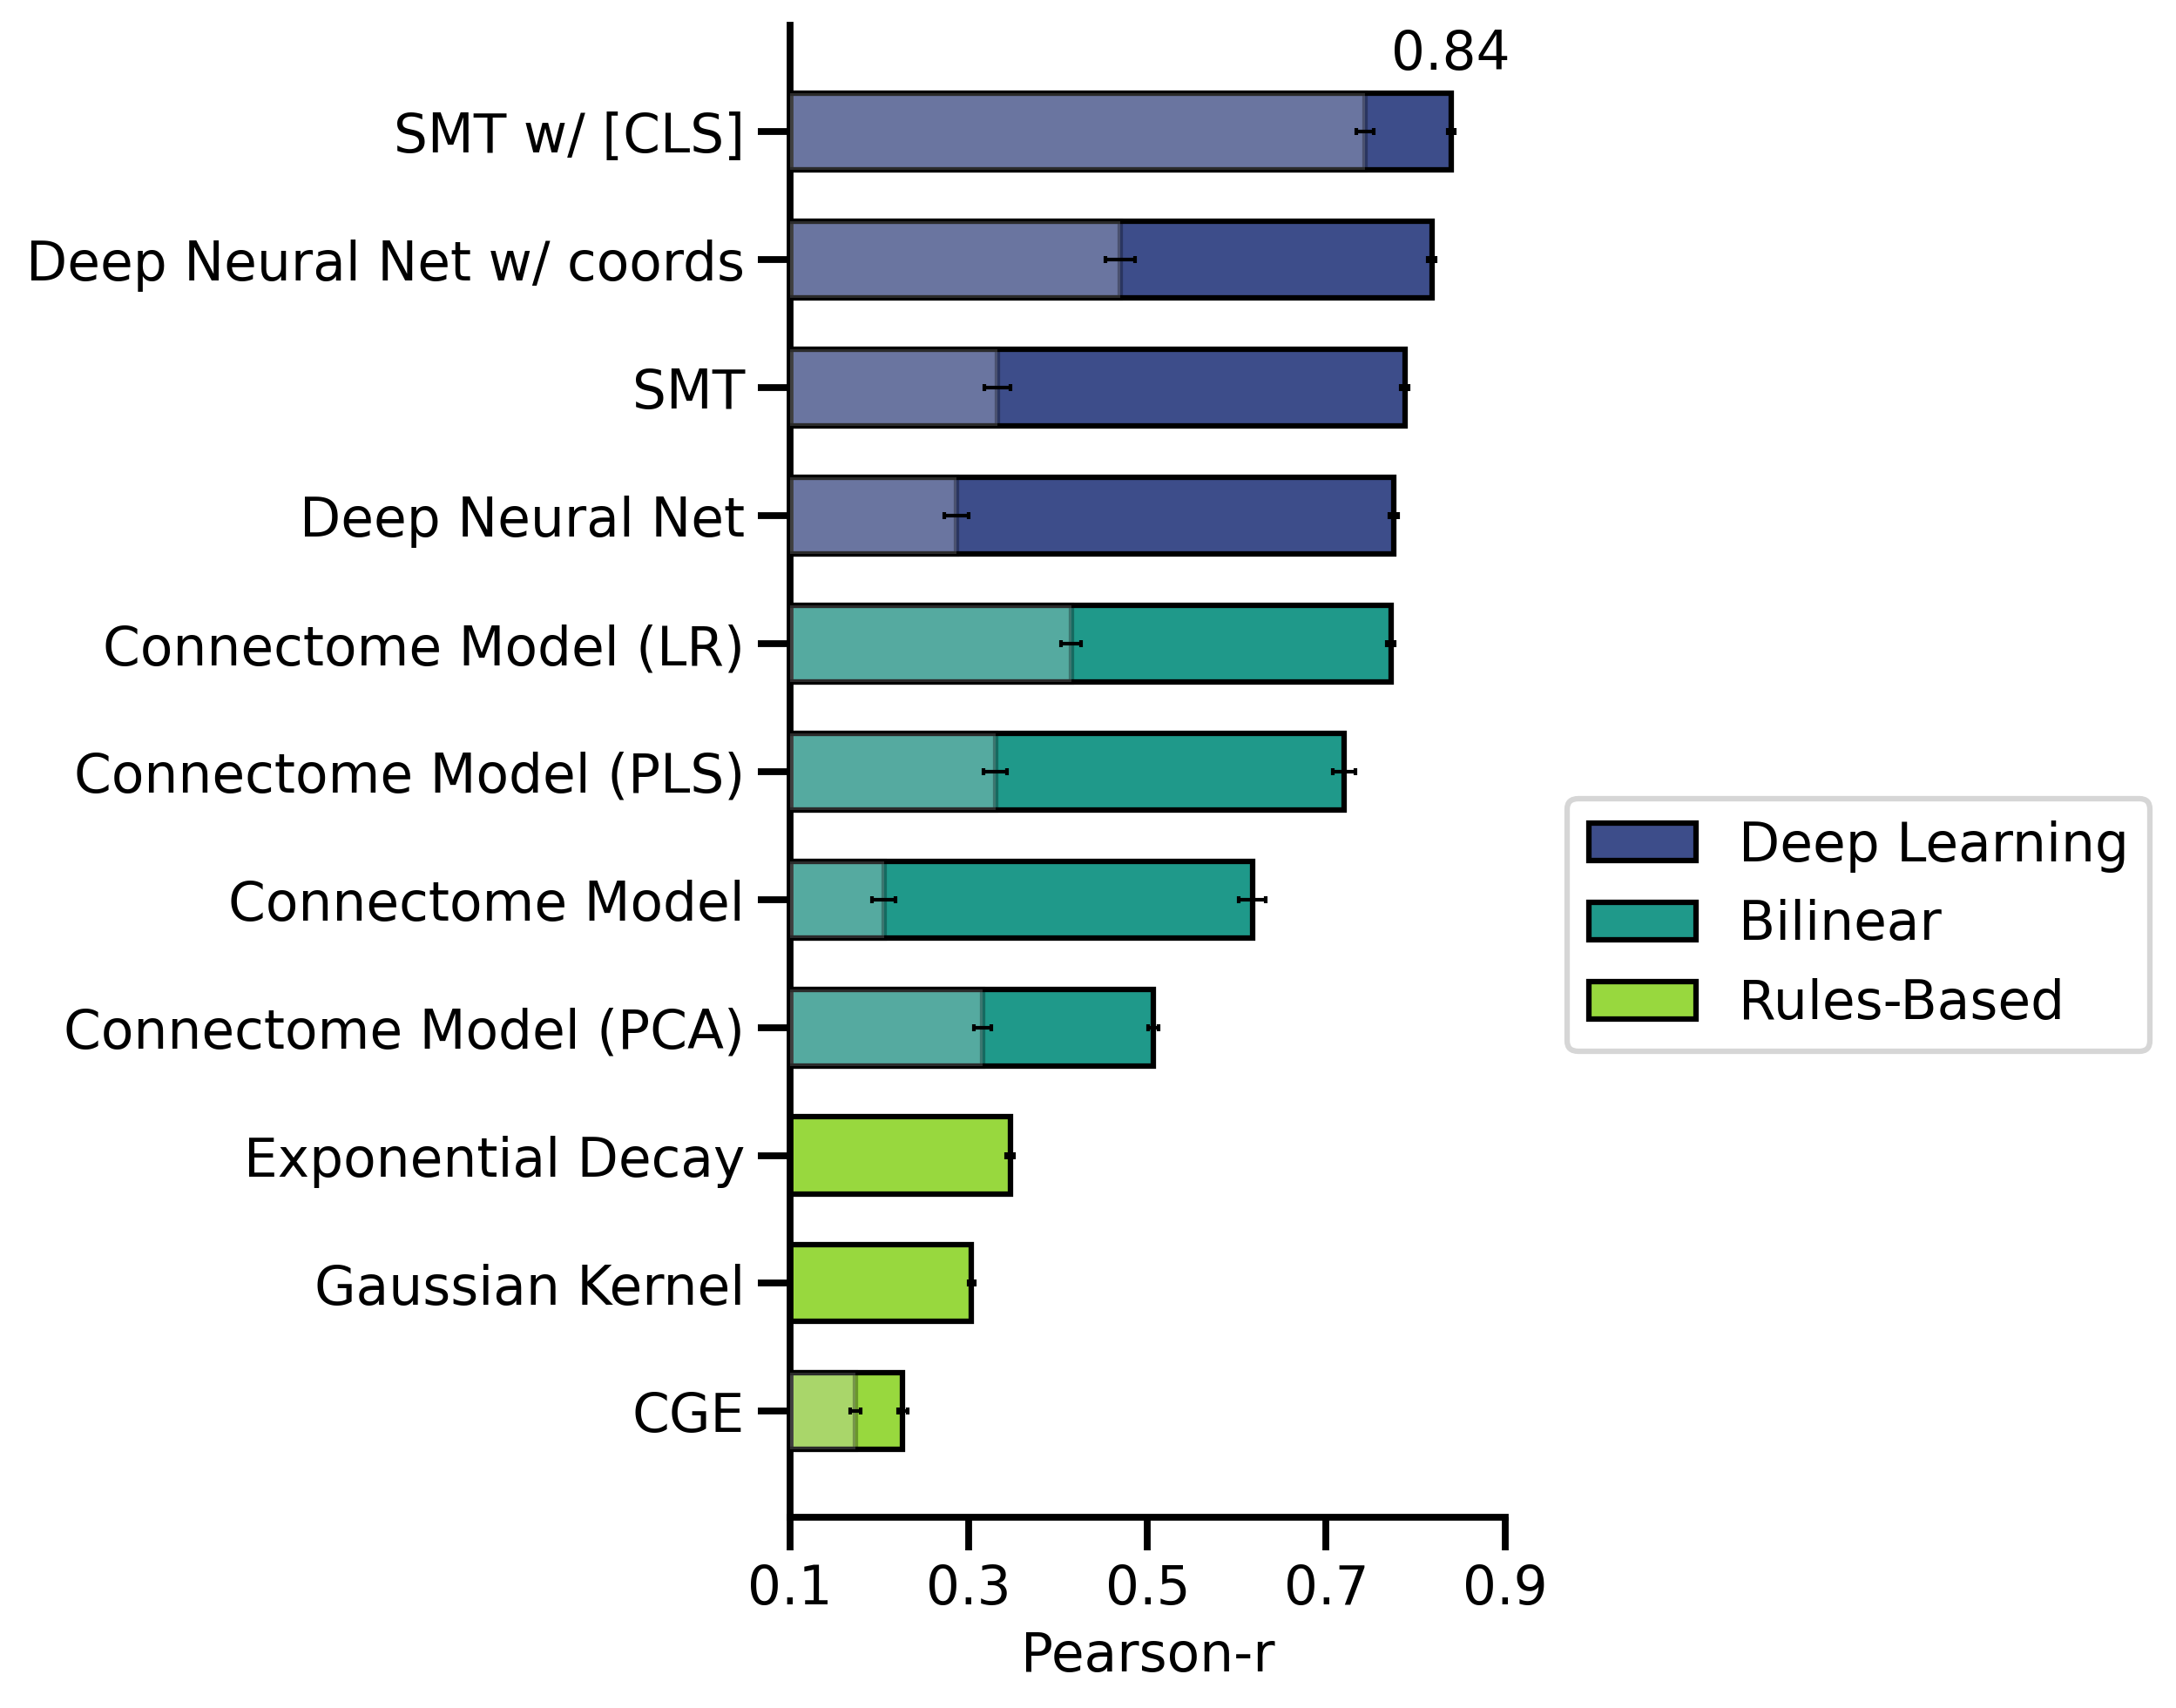

In [38]:
plot_true_vs_null_model_barchart_w_legend(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha'                          # or 'alpha'
)

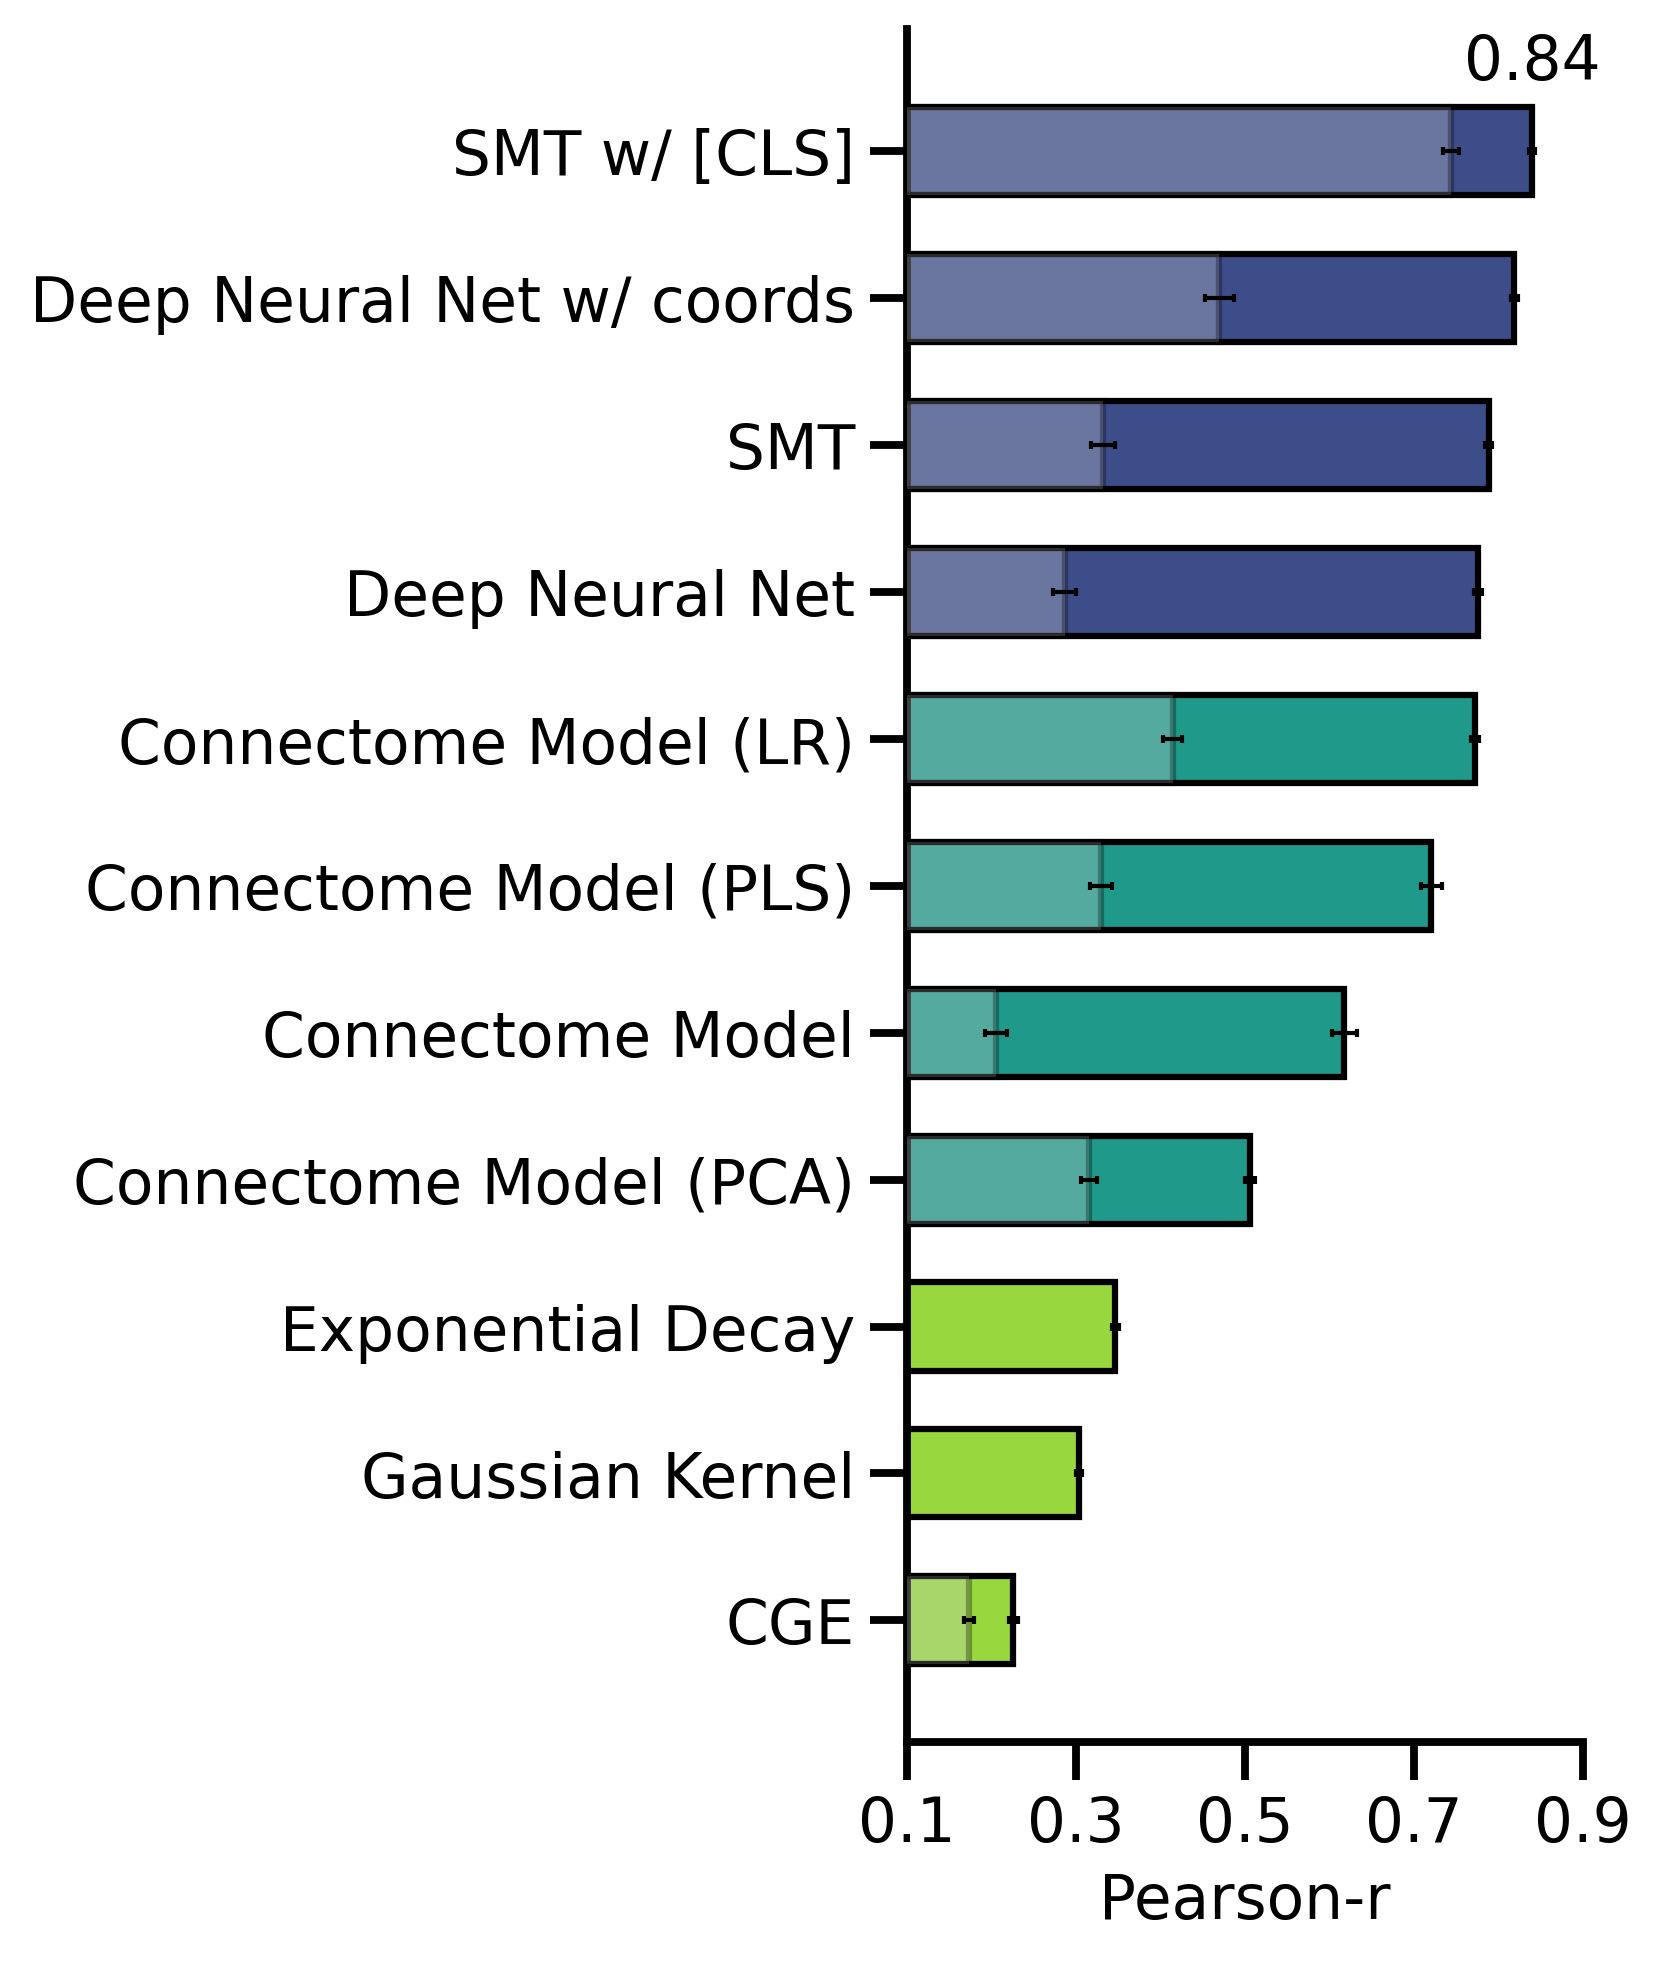

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [39]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.1, 0.9),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=False
)

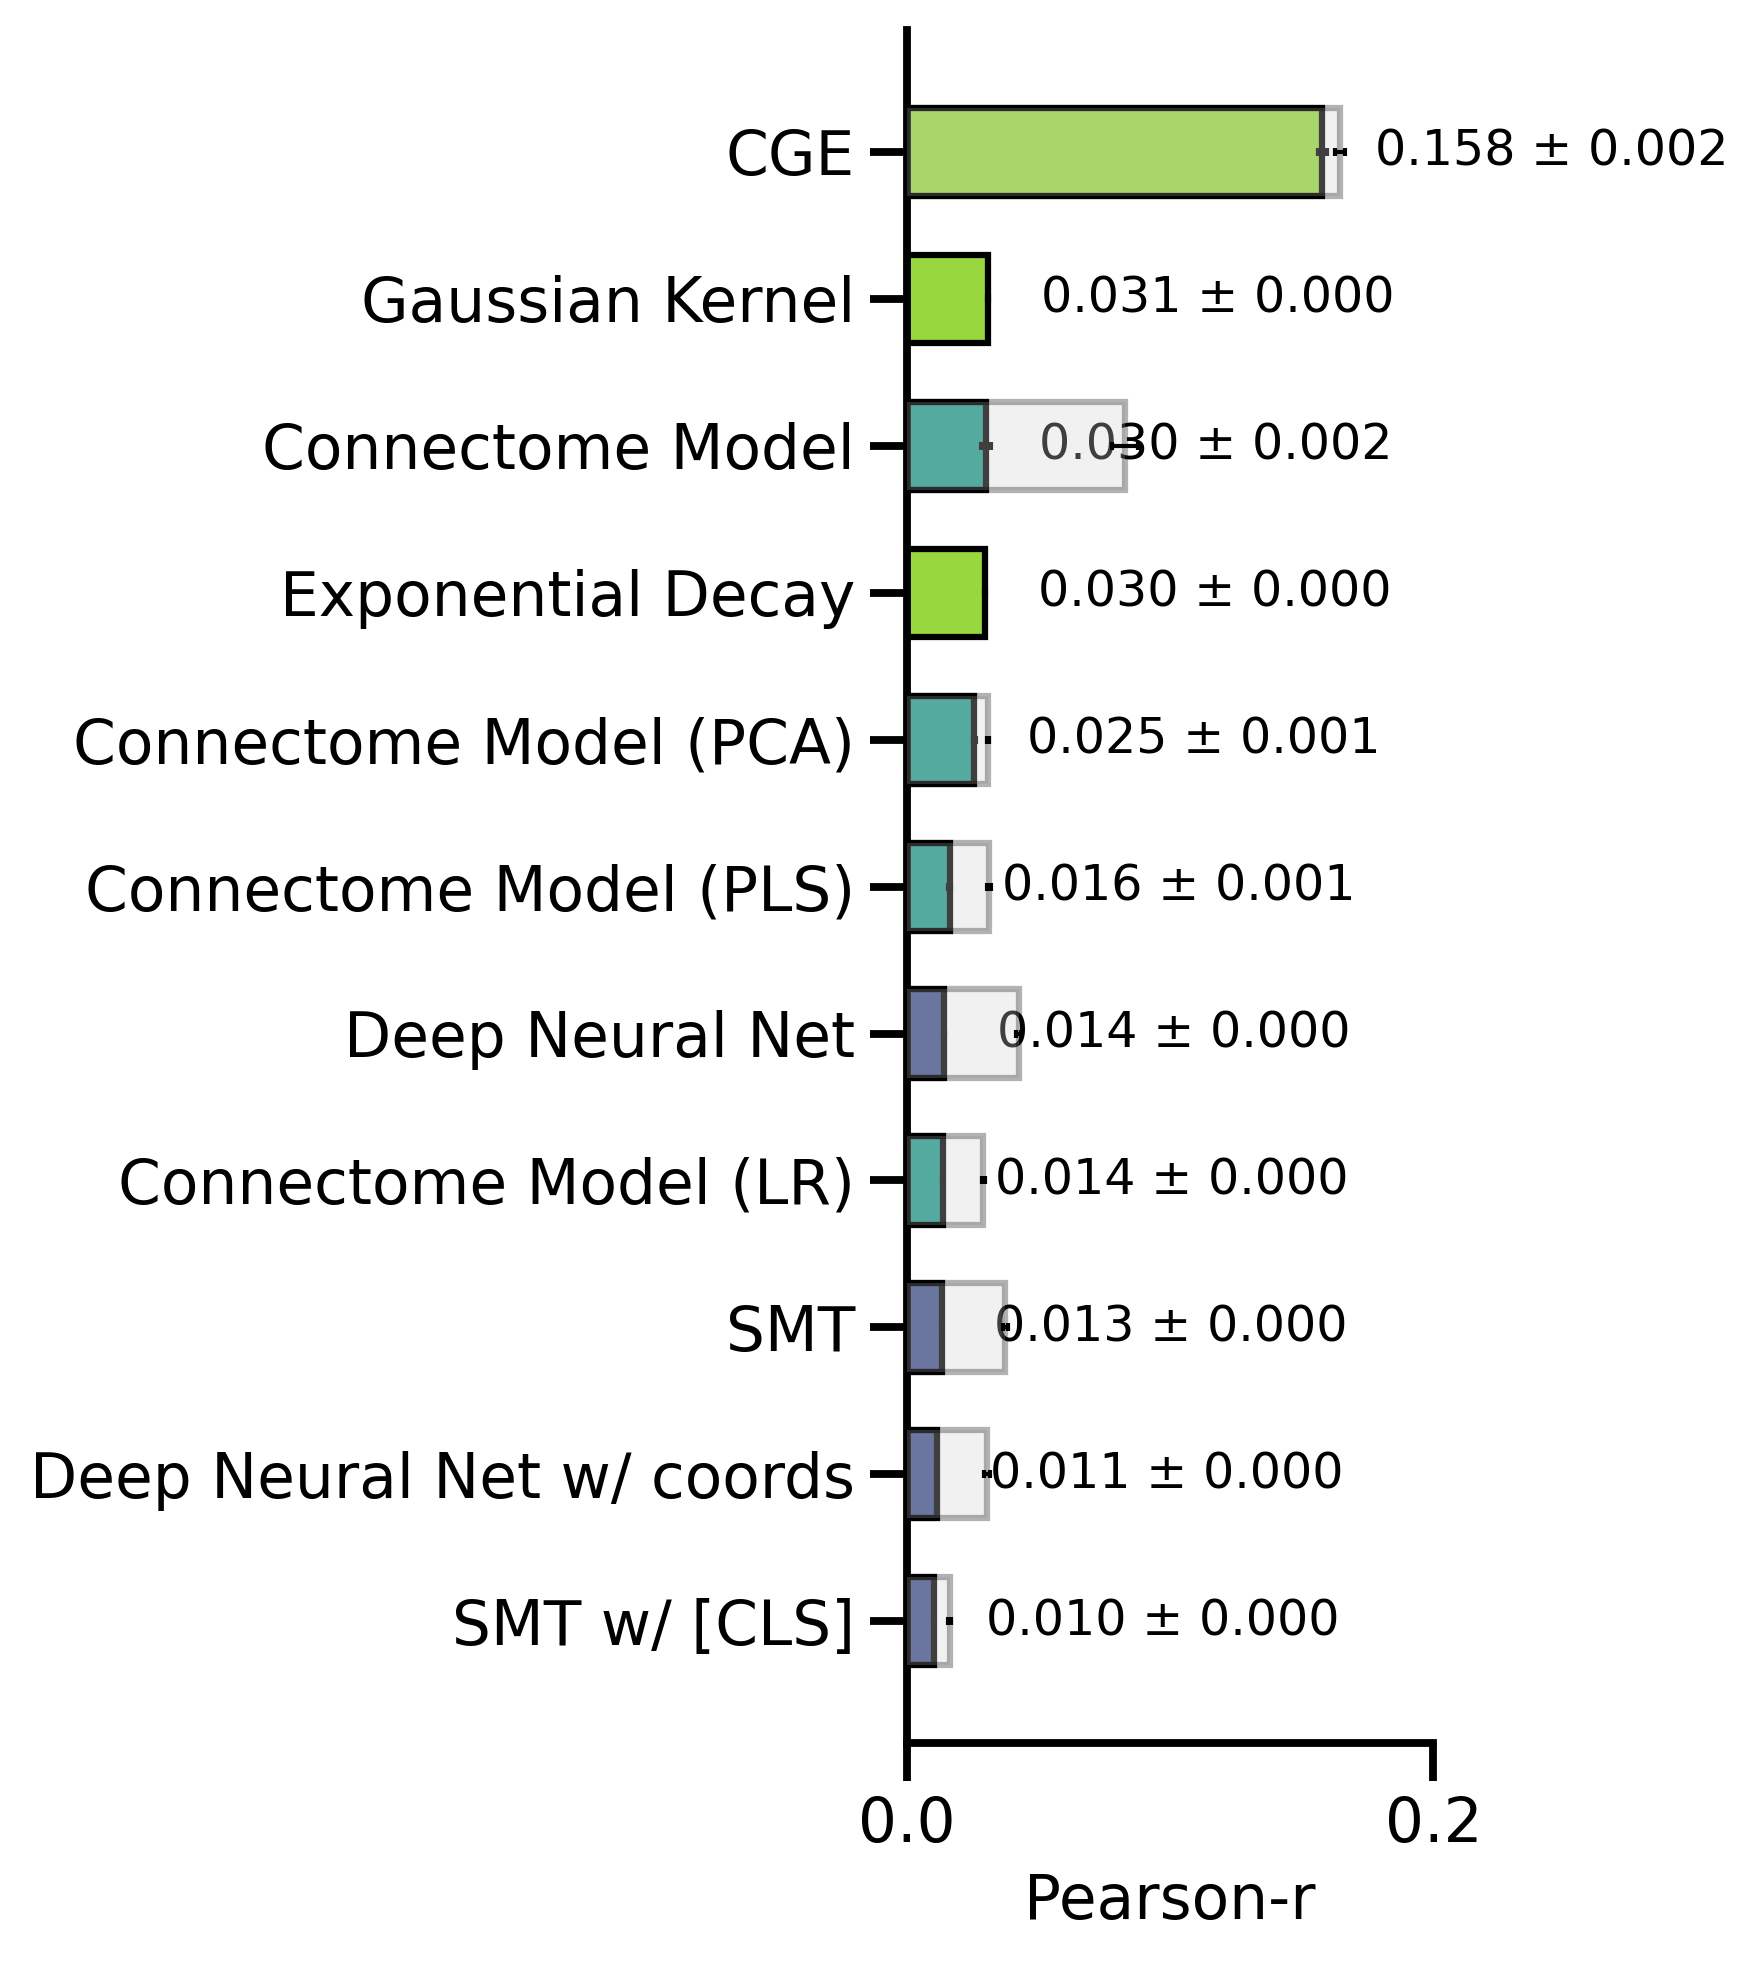

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [34]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_random,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_random_spin,           # cv_type='spatial', null_model='spin'
    metric="test_mse",
    xlim=(0.0, 0.05),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)

Search and plot spatial

In [40]:
# Define model groups and their valid feature types
models = ['cge', 'gaussian_kernel', 'exponential_decay',
          'bilinear_CM', 'pls_bilineardecoder', 'bilinear_lowrank',
          'dynamic_mlp', 'shared_transformer', 'shared_transformer_cls']

# Dictionary mapping models to their required feature types
model_feature_types = {
    'cge': ['transcriptome_PCA'],
    'gaussian_kernel': ['euclidean'],
    'exponential_decay': ['euclidean'],
    'bilinear_CM': ['transcriptome', 'transcriptome_PCA'],
    'pls_bilineardecoder': ['transcriptome'],
    'bilinear_lowrank': ['transcriptome'],
    'dynamic_mlp': ['transcriptome', 'transcriptome+euclidean'],
    'shared_transformer': ['transcriptome'],
    'shared_transformer_cls': ['transcriptome']
}

model_groups = {
    'rules based': ['cge', 'gaussian_kernel', 'exponential_decay'],
    'bilinear': ['bilinear_CM', 'bilinear_CM_PCA', 'pls_bilineardecoder', 'bilinear_lowrank'],
    'deep learning': ['dynamic_mlp', 'dynamic_mlp_coords', 'shared_transformer', 'shared_transformer_cls']
}


cv_type = 'spatial'
null_model = 'none'

within_last = 90
before_last = 0

# Store summary DataFrames
summary_dict_spatial = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_spatial, within_last=within_last, before_last=before_last)


cv_type = 'spatial'
null_model = 'spin'

# Store summary DataFrames
summary_dict_spatial_spin = {}
process_model_feature_combinations(cv_type, null_model, models, model_feature_types, summary_dict_spatial_spin, within_last=within_last, before_last=before_last)

Checking which model/feature type combinations return 40 runs for null_model=none:

🔍 Fetching runs for: model=cge, cv_type=spatial, null_model=none, feature_type=transcriptome_PCA
✓ cge with transcriptome_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=gaussian_kernel, cv_type=spatial, null_model=none, feature_type=euclidean
✓ gaussian_kernel with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=exponential_decay, cv_type=spatial, null_model=none, feature_type=euclidean
✓ exponential_decay with euclidean: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


✓ bilinear_CM: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome_PCA
✓ bilinear_CM_PCA: Successfully found 40 runs
🔍 Fetching runs for: model=pls_bilineardecoder, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ pls_bilineardecoder with transcriptome: Successfully found 40 runs
🔍 Fetching runs for: model=bilinear_lowrank, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ bilinear_lowrank with transcriptome: Successfully found 40 runs
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ dynamic_mlp: Successfully found 40 runs
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=none, feature_type=transcriptome+euclidean
✓ dynamic_mlp_coords: Successfully found 40 runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
✓ shared_transformer with transcriptome: Succe

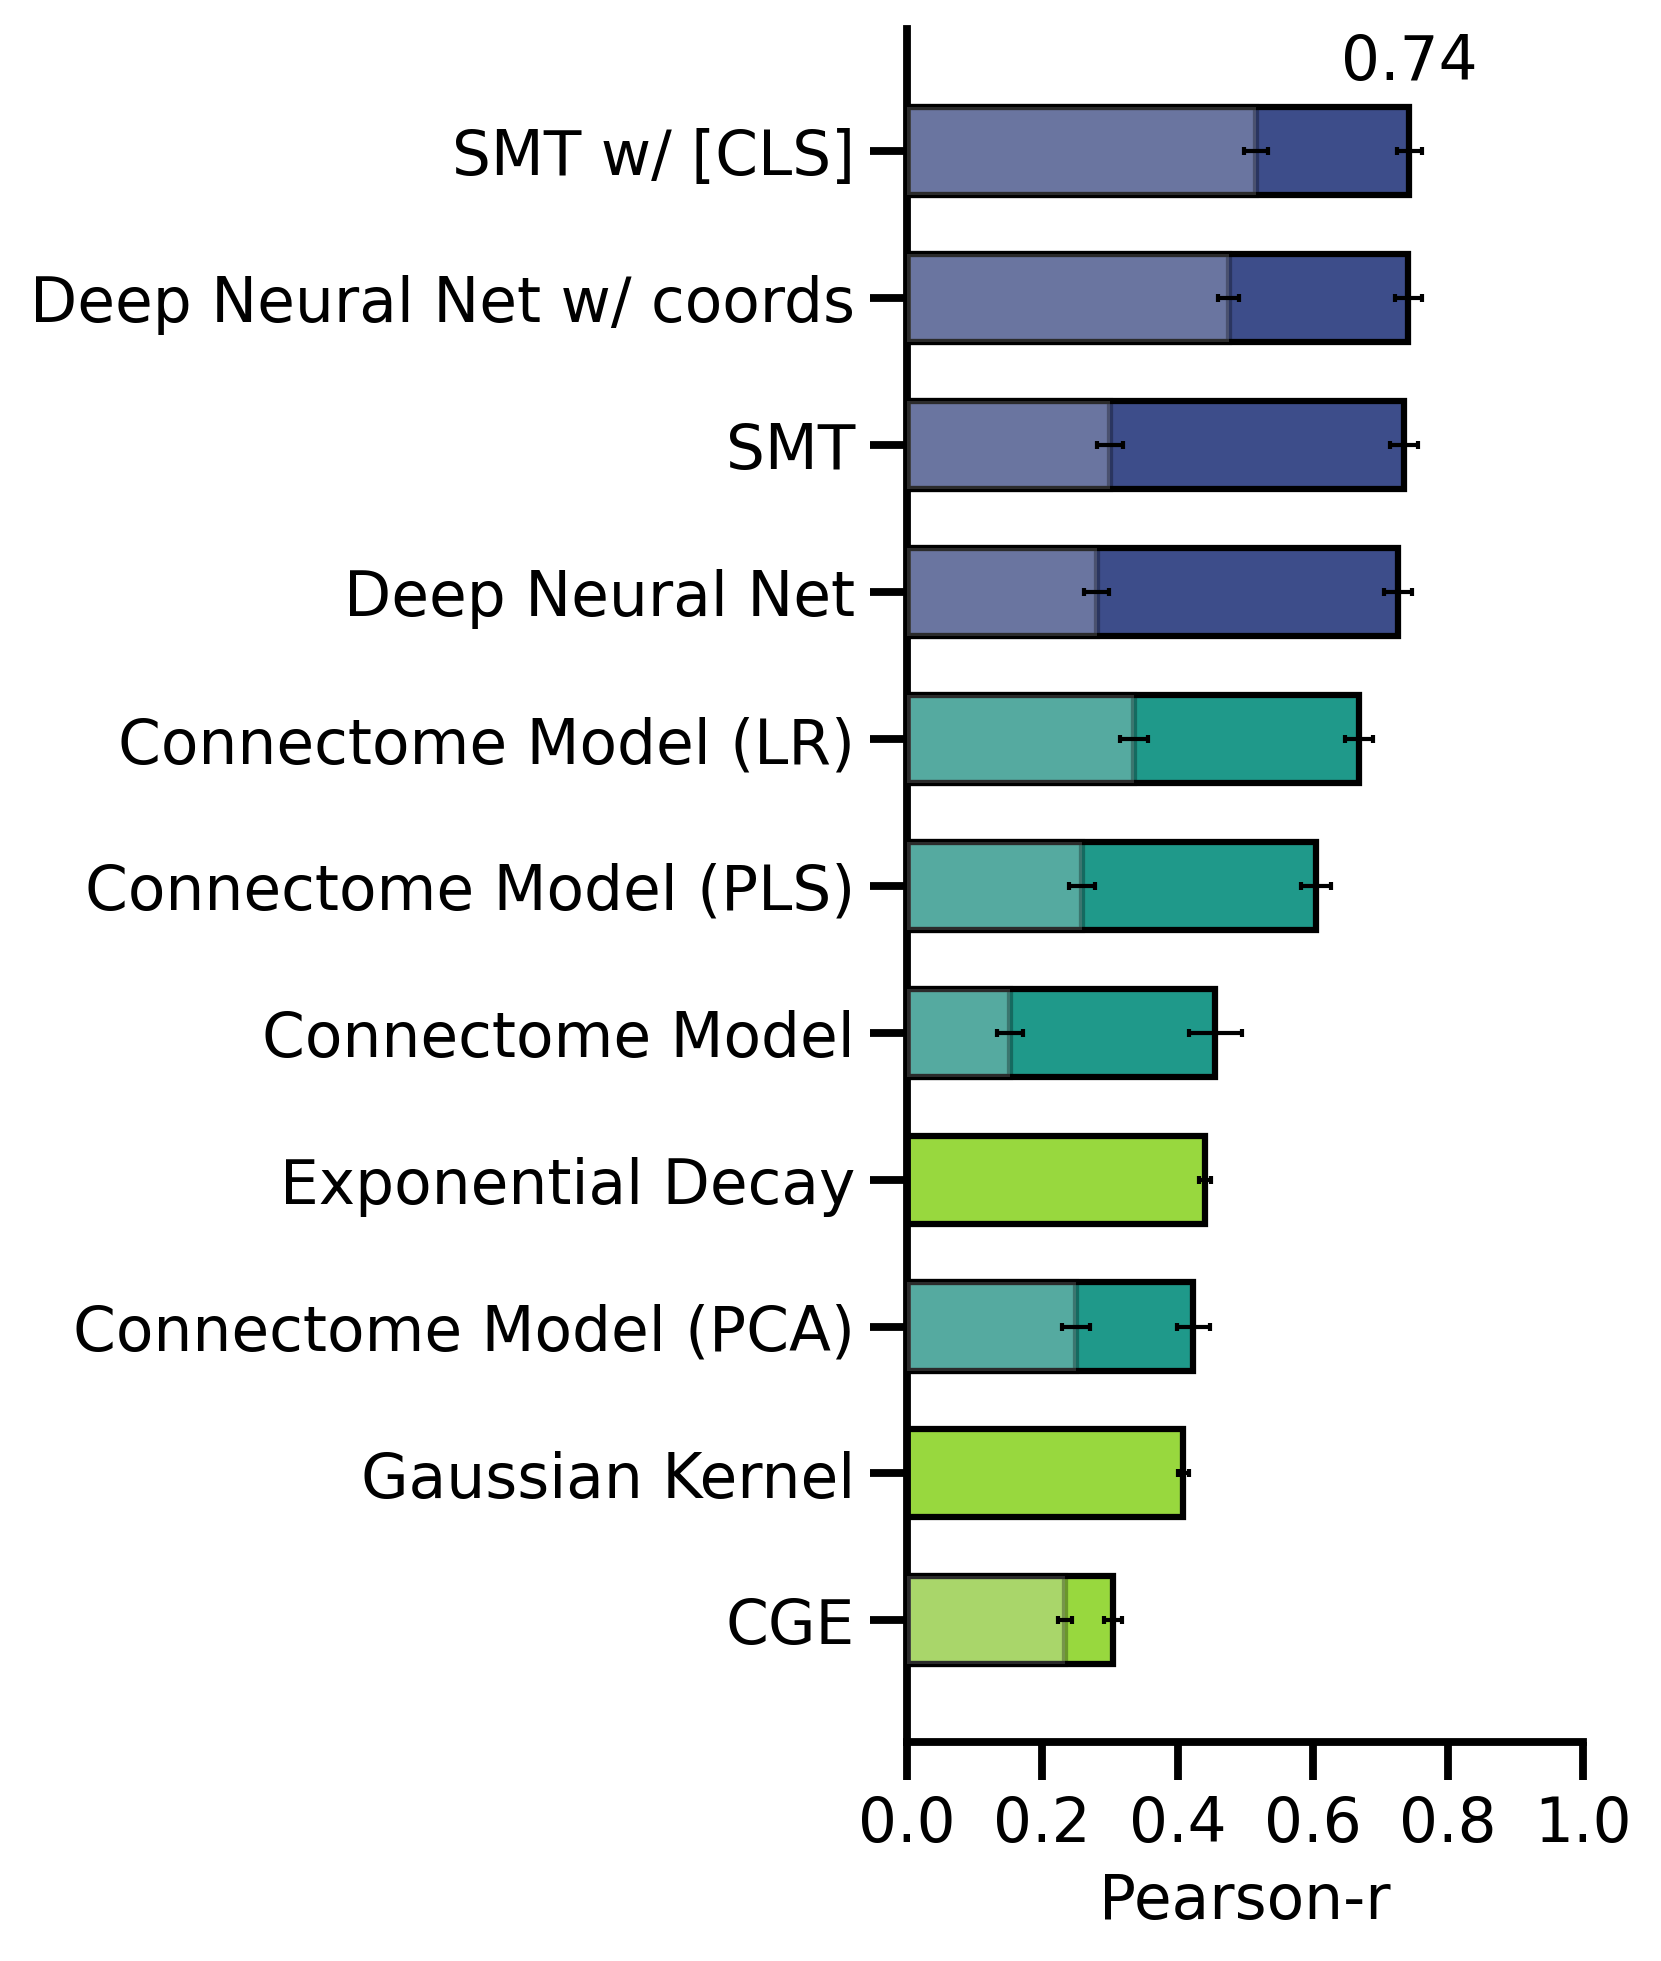

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [42]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_spatial,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.0, 1),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=False
)

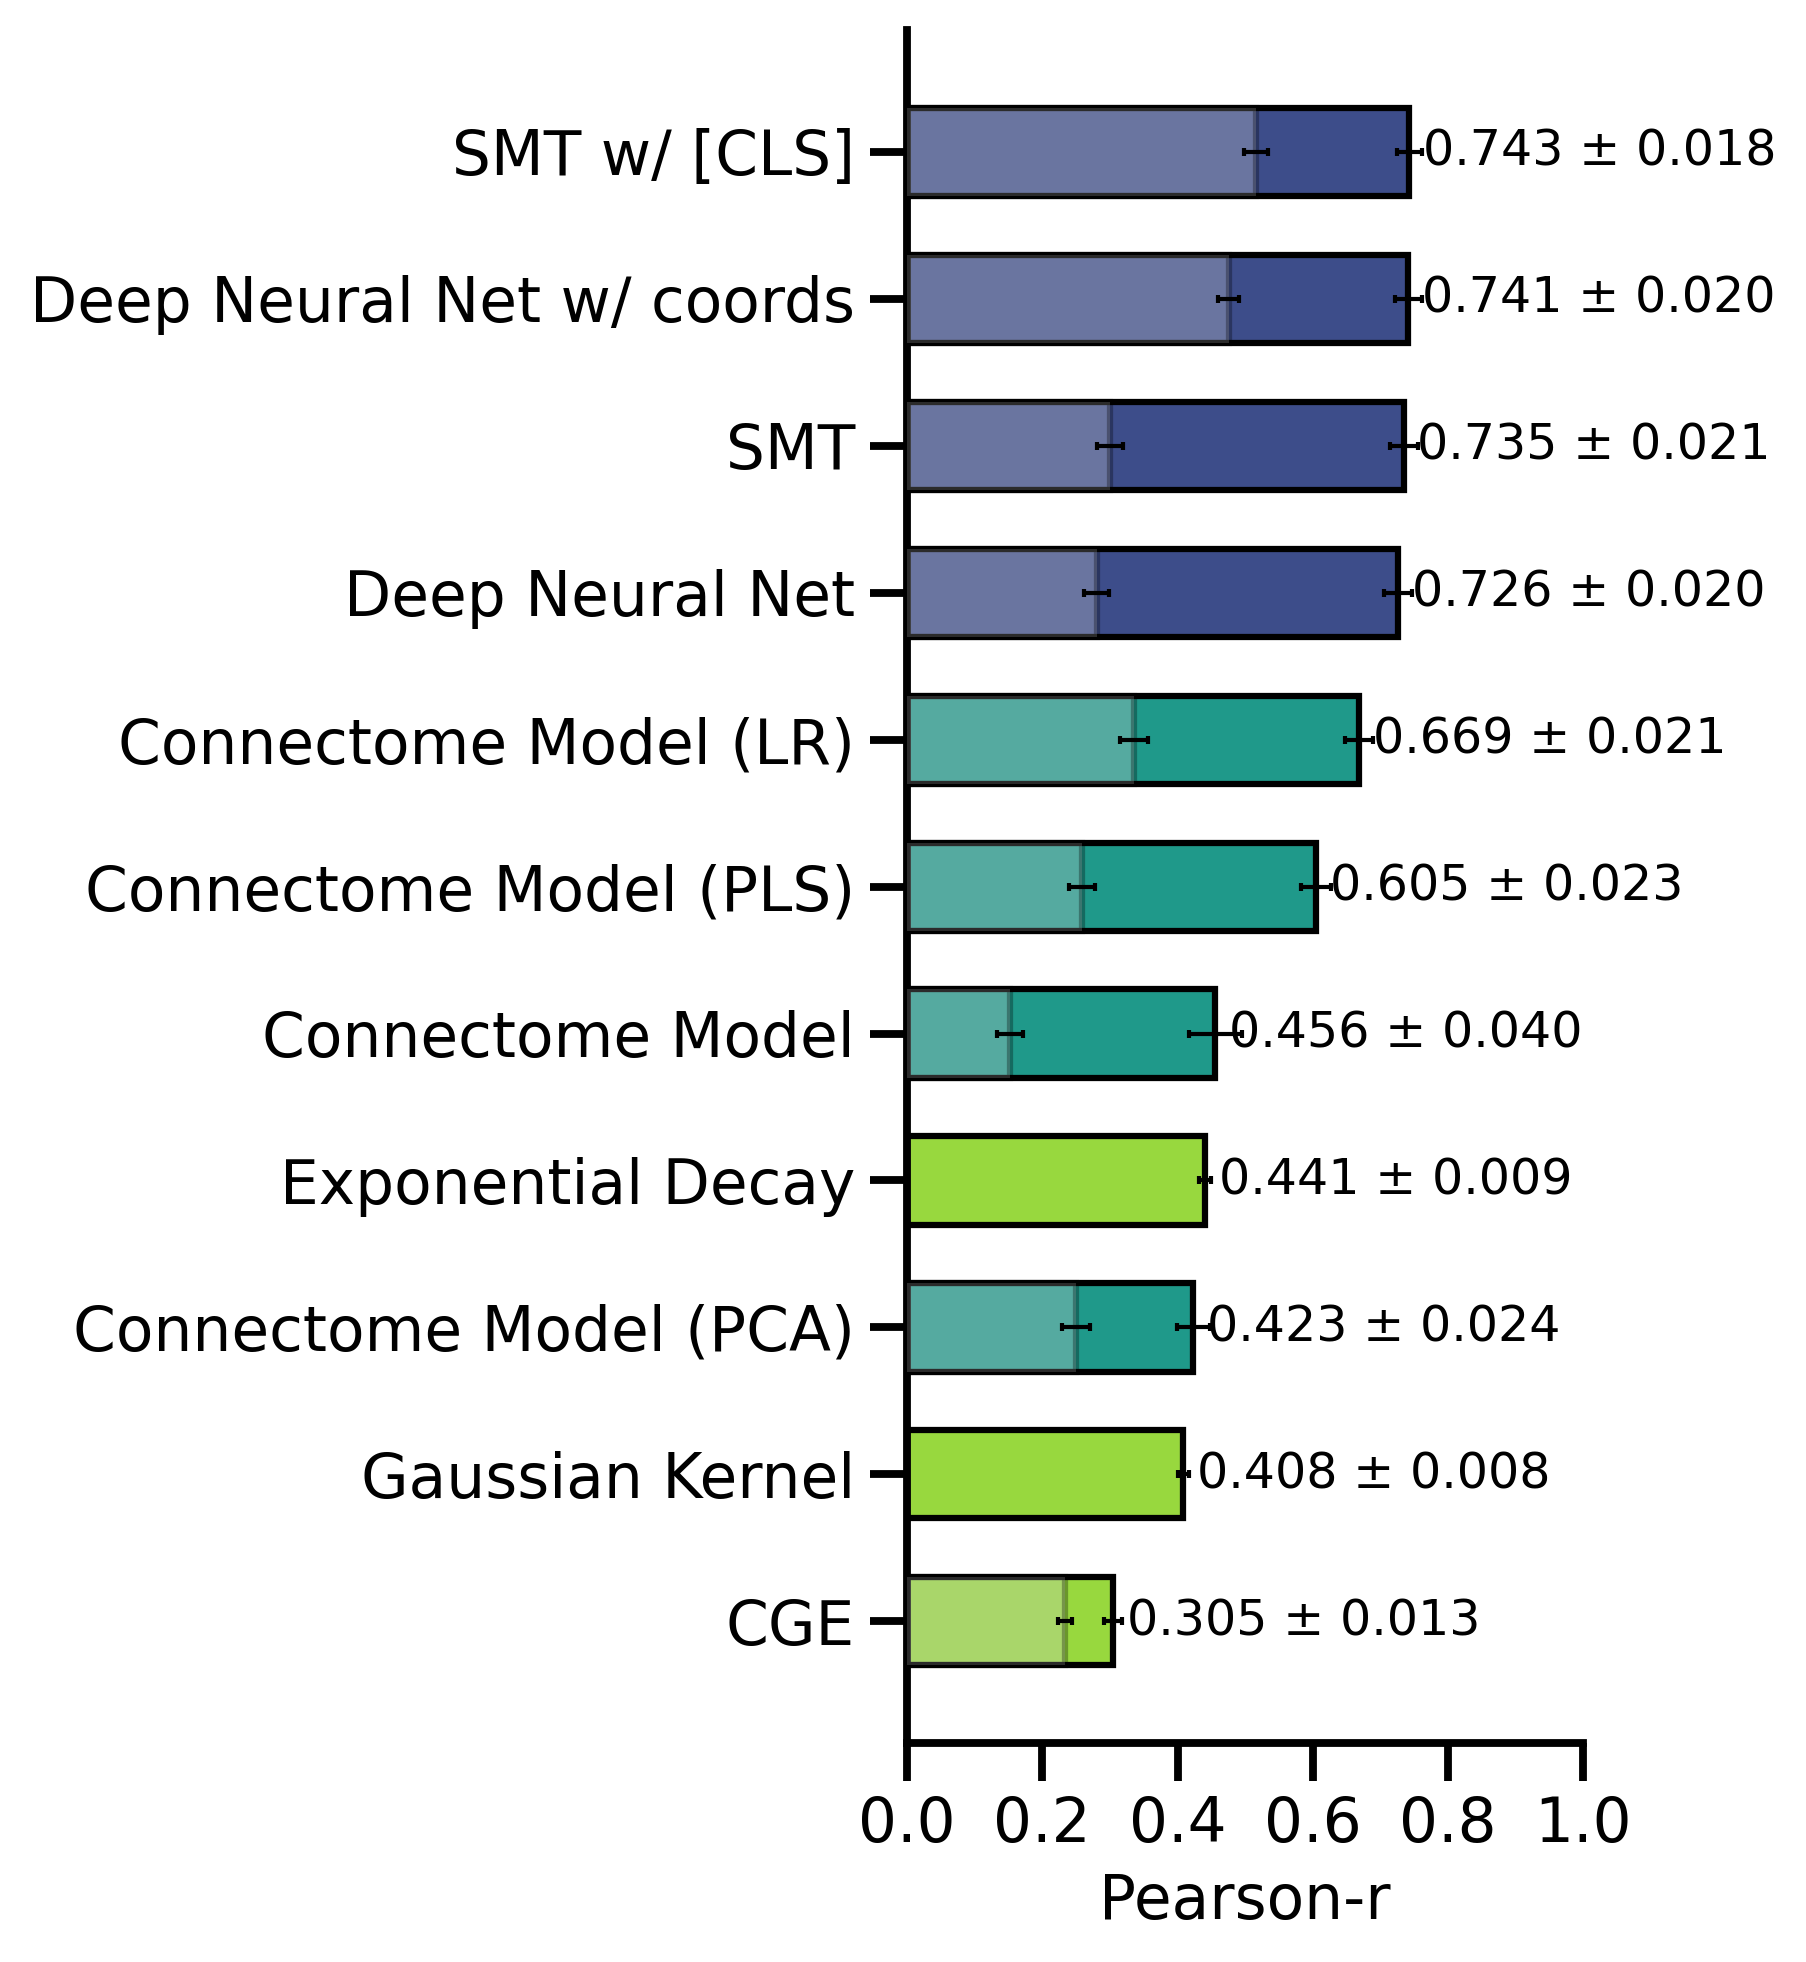

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [43]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_spatial,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.0, 1),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)

In [44]:
# Fetch data for top 5 models
summary_df_smt_cls, history_df_smt_cls = fetch_and_summarize_wandb_runs('shared_transformer_cls', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"SMT w/ [CLS]: {summary_df_smt_cls.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_smt_cls.loc['std', 'test_pearson_r']:.3f}")

summary_df_mlp_coords, history_df_mlp_coords = fetch_and_summarize_wandb_runs('dynamic_mlp', 'spatial', 'none', feature_type='transcriptome+euclidean', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Deep Neural Net w/ coords: {summary_df_mlp_coords.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_mlp_coords.loc['std', 'test_pearson_r']:.3f}")

summary_df_smt, history_df_smt = fetch_and_summarize_wandb_runs('shared_transformer', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"SMT: {summary_df_smt.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_smt.loc['std', 'test_pearson_r']:.3f}")

summary_df_mlp, history_df_mlp = fetch_and_summarize_wandb_runs('dynamic_mlp', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Deep Neural Net: {summary_df_mlp.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_mlp.loc['std', 'test_pearson_r']:.3f}")

summary_df_blr, history_df_blr = fetch_and_summarize_wandb_runs('bilinear_lowrank', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Connectome Model (LR): {summary_df_blr.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_blr.loc['std', 'test_pearson_r']:.3f}")

🔍 Fetching runs for: model=shared_transformer_cls, cv_type=spatial, null_model=none, feature_type=transcriptome
SMT w/ [CLS]: 0.723 ± 0.119
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=none, feature_type=transcriptome+euclidean
Deep Neural Net w/ coords: 0.732 ± 0.128
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
SMT: 0.725 ± 0.134
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=none, feature_type=transcriptome
Deep Neural Net: 0.718 ± 0.128
🔍 Fetching runs for: model=bilinear_lowrank, cv_type=spatial, null_model=none, feature_type=transcriptome
Connectome Model (LR): 0.669 ± 0.131


In [45]:
# Fetch data for top 5 models
summary_df_smt_cls, history_df_smt_cls = fetch_and_summarize_wandb_runs('shared_transformer_cls', 'spatial', 'spin', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"SMT w/ [CLS]: {summary_df_smt_cls.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_smt_cls.loc['std', 'test_pearson_r']:.3f}")

summary_df_mlp_coords, history_df_mlp_coords = fetch_and_summarize_wandb_runs('dynamic_mlp', 'spatial', 'spin', feature_type='transcriptome+euclidean', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Deep Neural Net w/ coords: {summary_df_mlp_coords.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_mlp_coords.loc['std', 'test_pearson_r']:.3f}")

summary_df_smt, history_df_smt = fetch_and_summarize_wandb_runs('shared_transformer', 'spatial', 'spin', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"SMT: {summary_df_smt.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_smt.loc['std', 'test_pearson_r']:.3f}")

summary_df_mlp, history_df_mlp = fetch_and_summarize_wandb_runs('dynamic_mlp', 'spatial', 'spin', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Deep Neural Net: {summary_df_mlp.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_mlp.loc['std', 'test_pearson_r']:.3f}")

summary_df_blr, history_df_blr = fetch_and_summarize_wandb_runs('bilinear_lowrank', 'spatial', 'spin', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)
print(f"Connectome Model (LR): {summary_df_blr.loc['mean', 'test_pearson_r']:.3f} ± {summary_df_blr.loc['std', 'test_pearson_r']:.3f}")

🔍 Fetching runs for: model=shared_transformer_cls, cv_type=spatial, null_model=spin, feature_type=transcriptome
SMT w/ [CLS]: 0.443 ± 0.126
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=spin, feature_type=transcriptome+euclidean
Deep Neural Net w/ coords: 0.384 ± 0.113
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=spin, feature_type=transcriptome
SMT: 0.283 ± 0.131
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=spin, feature_type=transcriptome
Deep Neural Net: 0.261 ± 0.118
🔍 Fetching runs for: model=bilinear_lowrank, cv_type=spatial, null_model=spin, feature_type=transcriptome
Connectome Model (LR): 0.336 ± 0.131


In [47]:
summary_df_smt_cls, history_df_smt_cls = fetch_and_summarize_wandb_runs('shared_transformer_cls', 'spatial', 'none', feature_type='transcriptome', use_weighted=False, exclude='HCP', return_history=True, within_last=60)

🔍 Fetching runs for: model=shared_transformer_cls, cv_type=spatial, null_model=none, feature_type=transcriptome


In [62]:
summary_df_blr['test_pearson_r']

mean      0.668508
std       0.130789
stderr    0.020680
Name: test_pearson_r, dtype: float64

In [52]:
history_df_blr['final_test_pearson_r'].tolist()

[0.8347339155528636,
 0.8293316597188712,
 0.8229584885401259,
 0.8205919515584069,
 0.8129796973768421,
 0.8095852691749817,
 0.8018394805117145,
 0.8015827346618584,
 0.7864373646313656,
 0.7771835462560556,
 0.7596221527792669,
 0.746183966891465,
 0.745757528346866,
 0.7447715113027605,
 0.7368192887778718,
 0.7247645641086932,
 0.70550815145401,
 0.6976743299161405,
 0.6944508516353926,
 0.6917002730991632,
 0.690614286818793,
 0.6779594303855898,
 0.6769683049236319,
 0.6624407158347838,
 0.6595185924316385,
 0.6570596993027024,
 0.6337032178850017,
 0.628525140202246,
 0.6255171302055681,
 0.6128468105773847,
 0.6123023884759752,
 0.5981953774938193,
 0.5613061447063918,
 0.5495890850492283,
 0.5296093185124154,
 0.4636101510200503,
 0.4499470664620851,
 0.40415064737191664,
 0.3974385236013245,
 0.30452658040894437]

In [53]:
history_df_mlp['final_test_pearson_r'].tolist()

[0.874816569962645,
 0.8724571973471211,
 0.8703571746589917,
 0.8690989429471985,
 0.8685544173330094,
 0.8617112594080543,
 0.8565127642661089,
 0.8428961644126794,
 0.8389984882242904,
 0.8334232415342407,
 0.828651535483567,
 0.8201802893198372,
 0.8179587188087954,
 0.8170118354722588,
 0.8156798235349443,
 0.8137723058889339,
 0.804445598246493,
 0.7942594264527413,
 0.793148529648569,
 0.7922800712114195,
 0.7864080669273183,
 0.7701031694926652,
 0.7578762533688137,
 0.7536577699007586,
 0.7454547822738147,
 0.7432853632676768,
 0.734724912602404,
 0.7299739861789324,
 0.7230713032959049,
 0.7217239261057004,
 0.7017521236682285,
 0.6057586814779825,
 0.596173691539155,
 0.5832538618283428,
 0.5756978437039861,
 0.5494087840932648,
 0.5023435237792977,
 0.4620214298464263,
 0.45742152513362067,
 0.4512233251900739]

In [54]:
history_df_smt_cls['final_test_pearson_r'].tolist()

[0.8763978946308446,
 0.8718014396840108,
 0.8472944306210438,
 0.8470304927601671,
 0.8418965224297131,
 0.8369845071579434,
 0.8353700641514276,
 0.8314822940299853,
 0.8291554348839184,
 0.8266906487908552,
 0.822099896752721,
 0.8203711377852543,
 0.8106524570191244,
 0.8092754247922952,
 0.8076308496570355,
 0.8043687755037591,
 0.7885233791890677,
 0.7862125641996757,
 0.7834406093672405,
 0.7797993318217715,
 0.7783796847100262,
 0.7706662935334172,
 0.7650346469845258,
 0.7627117312180713,
 0.7603906419771065,
 0.7484670708456334,
 0.7460003940100796,
 0.7365401486488546,
 0.726964119995968,
 0.7265934037607695,
 0.7239577855982594,
 0.6693030392813027,
 0.660066468423314,
 0.5988156396659523,
 0.5942075113678246,
 0.5724997129880625,
 0.5013290098751826,
 0.4914150596472009,
 0.4645252166274094,
 0.46179245464797825]

In [55]:
from scipy.stats import ttest_rel

# Extract lists of Pearson r values
mlp_vals = history_df_mlp['final_test_pearson_r'].tolist()
smt_cls_vals = history_df_smt_cls['final_test_pearson_r'].tolist()

# Perform two-sided paired t-test
t_stat, p_val = ttest_rel(mlp_vals, smt_cls_vals)

# Format p-value appropriately
p_str = f"{p_val:.4f}" if p_val >= 1e-4 else f"{p_val:.1e}"

print("Paired t-test result:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value:     {p_str}")

Paired t-test result:
  t-statistic: -0.6294
  p-value:     0.5328


In [56]:
from scipy.stats import ttest_rel

# Extract lists of Pearson r values
blr_vals = history_df_blr['final_test_pearson_r'].tolist()
smt_cls_vals = history_df_smt_cls['final_test_pearson_r'].tolist()

# Perform two-sided paired t-test
t_stat, p_val = ttest_rel(blr_vals, smt_cls_vals)

# Format p-value appropriately
p_str = f"{p_val:.4f}" if p_val >= 1e-4 else f"{p_val:.1e}"

print("Paired t-test result:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value:     {p_str}")

Paired t-test result:
  t-statistic: -15.4380
  p-value:     3.3e-18


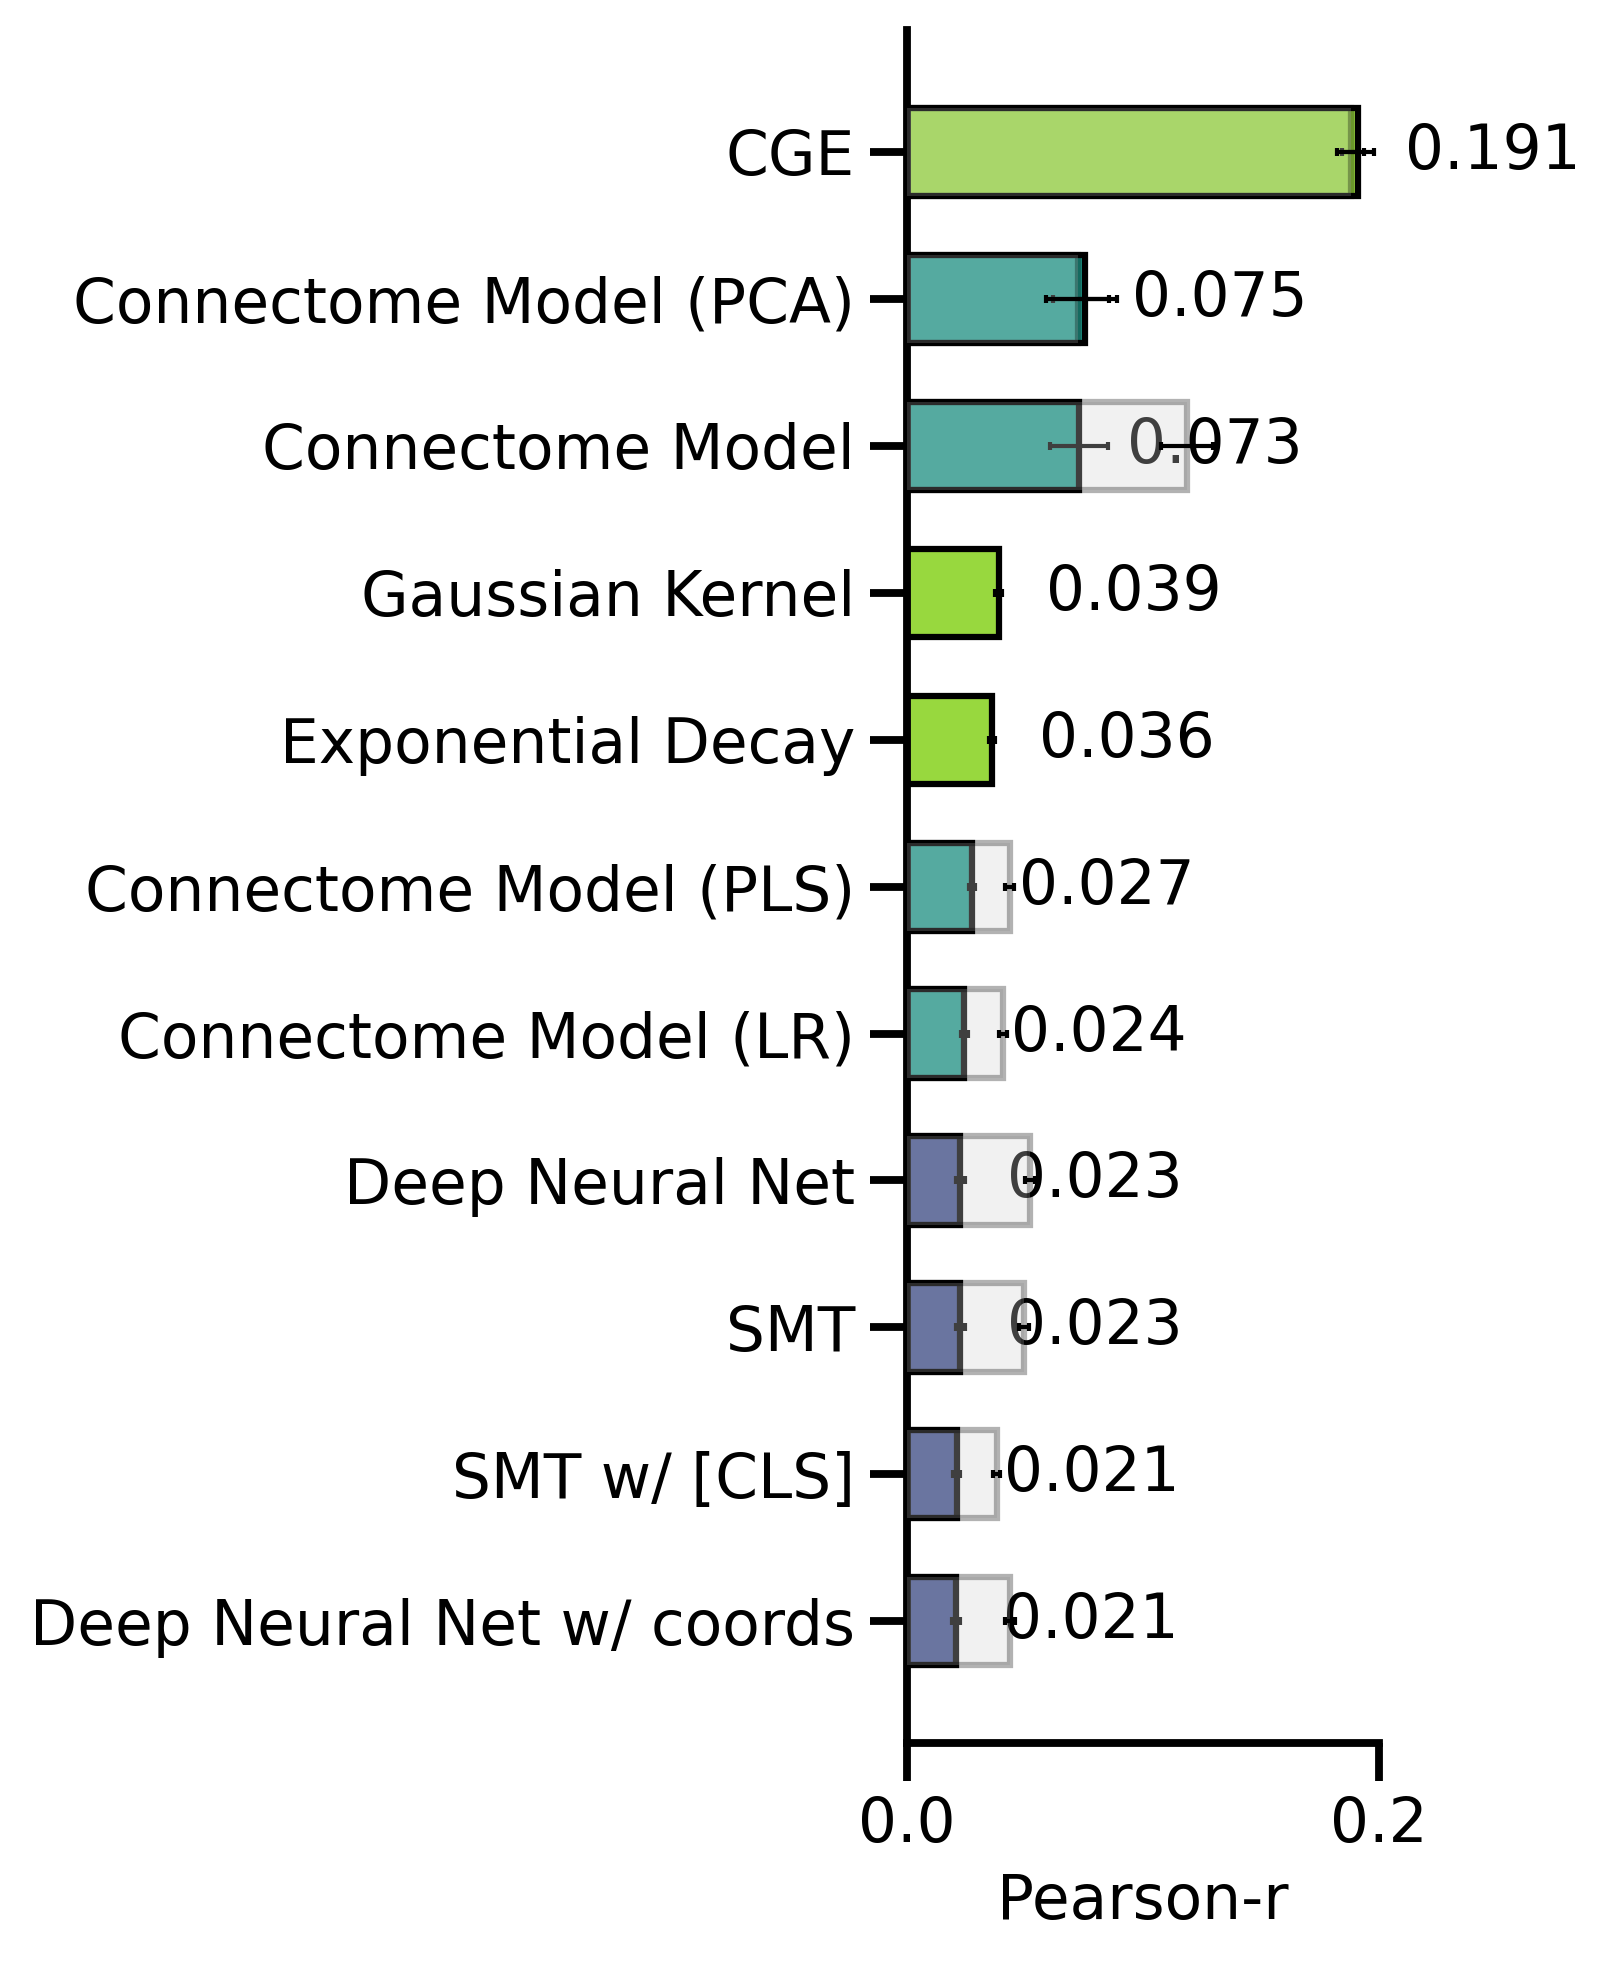

{'Non-Linear': (0.239346, 0.300855, 0.540844),
 'Bilinear': (0.120092, 0.600104, 0.54253),
 'Feature Based': (0.595839, 0.848717, 0.243329)}

In [28]:
plot_true_vs_null_model_barchart(
    summary_true_dict=summary_dict_spatial,                # cv_type='spatial', null_model='none'
    summary_null_dict=summary_dict_spatial_spin,           # cv_type='spatial', null_model='spin'
    metric="test_pearson_r",
    xlim=(0.0, .05),
    overlay_style='alpha',                          # or 'alpha'
    display_metric=True
)